In [20]:
# Import necessary libraries
from web3 import Web3
import json
import solcx
import random
import matplotlib.pyplot as plt

# Connect to the local Ethereum network (Ganache)
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))

# Check if connection is successful
if not w3.is_connected():
    raise Exception("Failed to connect to the Ethereum network")

# Set the default account (deployer)
w3.eth.default_account = w3.eth.accounts[0]

# Compile the contract using solcx
solcx.install_solc('0.8.0')
solcx.set_solc_version('0.8.0')

# Path to your Solidity contract
contract_path = "./ProofOfReputation.sol"  # Update this path to your contract

# Compile the Solidity contract
with open(contract_path, "r") as file:
    contract_source_code = file.read()

compiled_sol = solcx.compile_standard({
    "language": "Solidity",
    "sources": {
        "ProofOfReputation.sol": {
            "content": contract_source_code
        }
    },
    "settings": {
        "outputSelection": {
            "*": {
                "*": ["abi", "metadata", "evm.bytecode", "evm.sourceMap"]
            }
        }
    }
})

# Extract ABI and bytecode
abi = compiled_sol['contracts']['ProofOfReputation.sol']['ProofOfReputation']['abi']
bytecode = compiled_sol['contracts']['ProofOfReputation.sol']['ProofOfReputation']['evm']['bytecode']['object']

# Deploy the contract
ProofOfReputation = w3.eth.contract(abi=abi, bytecode=bytecode)
tx_hash = ProofOfReputation.constructor().transact()
tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
contract_address = tx_receipt.contractAddress
print(f"Contract deployed at address: {contract_address}")

# Get the deployed contract instance
deployed_contract = w3.eth.contract(address=contract_address, abi=abi)

# Initialize data storage
reputation_history = {address: [] for address in w3.eth.accounts[1:]}  # Adjust for the number of clients
validation_costs = []
selected_validators = []

# Function to log gas used
def log_gas_usage(tx_hash, action):
    receipt = w3.eth.get_transaction_receipt(tx_hash)
    # print(f"Gas used for {action}: {receipt.gasUsed}")
    return receipt.gasUsed

# Add a new client with initialized parameters
def add_client(client_address, initial_reputation, historical_performance, trustworthiness, contribution, peer_reviews, validation_accuracy):
    try:
        tx_hash = deployed_contract.functions.addClient(
            client_address,
            initial_reputation,
            historical_performance,
            trustworthiness,
            contribution,
            peer_reviews,
            validation_accuracy
        ).transact()
    except Exception as e:
        print(f"Error adding client {client_address}: {str(e)}")

# Submit a job
def submit_job(client_address, job_result):
    try:
        tx_hash = deployed_contract.functions.submitJob(job_result).transact({'from': client_address})
    except Exception as e:
        print(f"Error submitting job by client {client_address}: {str(e)}")

# Validate all jobs, specifying success or failure for each client
def validate_all_jobs(validator_address, successes):
    try:
        tx_hash = deployed_contract.functions.validateAllJobs(successes).transact({'from': validator_address})
        gas_used = log_gas_usage(tx_hash, "Validating all jobs")
        validation_costs.append(gas_used)
    except Exception as e:
        print(f"Error validating jobs by validator {validator_address}: {str(e)}")

# Fetching updated reputations
def get_reputation(client_address):
    try:
        reputation = deployed_contract.functions.getReputationScore(client_address).call()
        return reputation
    except Exception as e:
        print(f"Error fetching reputation for client {client_address}: {str(e)}")
        return 0

# Run the test with K clients and N rounds
def run_test(K, N):
    print(f"Running test with {K} clients and {N} rounds\n")
    
    # Add K clients with initialized parameters
    for i in range(1, K + 1):
        initial_reputation = random.randint(1000, 1500)
        # initial_reputation = 10000
        historical_performance = random.randint(0, 10)
        trustworthiness = random.randint(0, 10)
        contribution = random.randint(0, 10)
        peer_reviews = random.randint(0, 10)
        validation_accuracy = random.randint(0, 10)

        add_client(
            w3.eth.accounts[i], 
            initial_reputation,
            historical_performance,
            trustworthiness,
            contribution,
            peer_reviews,
            validation_accuracy
        )
        print(f"Initialized reputation of client {w3.eth.accounts[i]} is {initial_reputation}")
    
    # Run N rounds of job submissions and validations
    for round_num in range(1, N + 1):
        # print(f"\n--- Round {round_num} ---")
        
        # Each client submits a job
        for i in range(1, K + 1):
            submit_job(w3.eth.accounts[i], f"Job {round_num} from Client {i}")
        
        # Randomly decide if each job is successful or not
        successes = [random.choice([True, False]) for _ in range(K)]

        # Validator validates all jobs
        current_validator = deployed_contract.functions.getCurrentValidator().call()
        # print(f"Current Validator: {current_validator}")
        validate_all_jobs(current_validator, successes)
        selected_validators.append(current_validator)
        
        # Store the updated reputations
        for i in range(1, K + 1):
            reputation = get_reputation(w3.eth.accounts[i])
            reputation_history[w3.eth.accounts[i]].append(reputation)

font = {'family': 'serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)
# Plot the results
def plot_results(K, N):
    rounds = list(range(1, N + 1))

    # Plot reputation per round
    plt.figure(figsize=(8, 4))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # List of markers for different lines
    for i in range(1, K + 1):
        plt.plot(rounds, reputation_history[w3.eth.accounts[i]], marker=markers[i % len(markers)], label=f"Client {i} ({w3.eth.accounts[i][:10]}...)")
    # plt.title('Reputation Per Round')
    plt.xlabel('Round')
    plt.ylabel('Reputation')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Combine validation cost and selected validators per round
    fig, ax1 = plt.subplots(figsize=(8, 4))

    color = 'tab:blue'
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Gas Used', color=color)
    ax1.plot(rounds, validation_costs, marker='o', color=color, linestyle='-', label='Validation Costs')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    validator_labels = [f"Client {i + 1}" for i in range(K)]
    validator_indices = [validator_labels[w3.eth.accounts.index(v) - 1] for v in selected_validators]
    ax2.set_ylabel('Selected Validator', color=color)
    ax2.plot(rounds, validator_indices, marker='x', linestyle='-', color=color, label='Selected Validators')
    ax2.tick_params(axis='y', labelcolor=color)

    # plt.title('Validation Costs and Selected Validators Per Round')
    plt.xlabel('Round')
    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.show()




Contract deployed at address: 0xc72a6F00c39C74732F0A7A66e8963Aa0ebCEc67C


set 1-1: 
Running test with 3 clients and 50 rounds

Initialized reputation of client 0x86434733BC5cFd9DAa7F6a9fAefb91D31f2BFEC7 is 1430
Initialized reputation of client 0x02Fa249f75951c56549c8cf86c75b4Cbe04E6F4C is 1230
Initialized reputation of client 0x3c2595d4c5eC58fcBde6eBE5aD313F66AE4384Fb is 1182


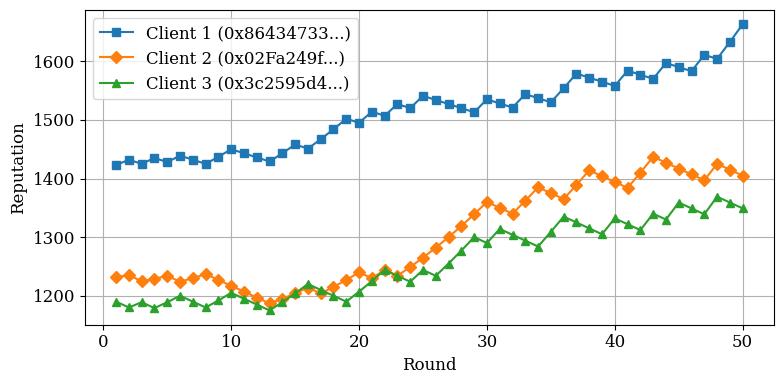

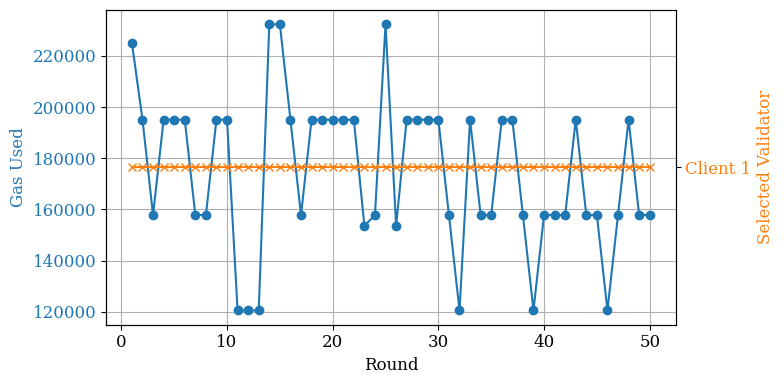

In [13]:
# Example usage: Test with 10 clients over 10 rounds
print("set 1-1: ")
run_test(K=3, N=50)
plot_results(K=3, N=50)

set 2-1: 
Running test with 6 clients and 50 rounds

Initialized reputation of client 0x86434733BC5cFd9DAa7F6a9fAefb91D31f2BFEC7 is 1093
Initialized reputation of client 0x02Fa249f75951c56549c8cf86c75b4Cbe04E6F4C is 1043
Initialized reputation of client 0x3c2595d4c5eC58fcBde6eBE5aD313F66AE4384Fb is 1355
Initialized reputation of client 0x89592a2c6aA603eF1526C09001793E7EAfb6f60C is 1238
Initialized reputation of client 0xba74589246157E8fE25F29f678B5738a51A454db is 1371
Initialized reputation of client 0x8BA41Feb6Da7467cb4685e0B58fE807E23167A41 is 1390


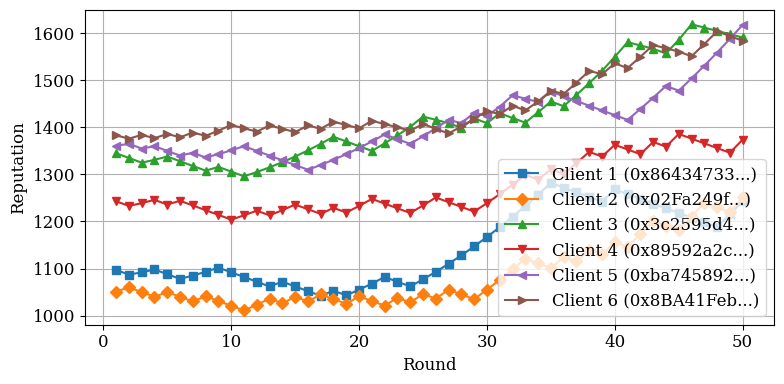

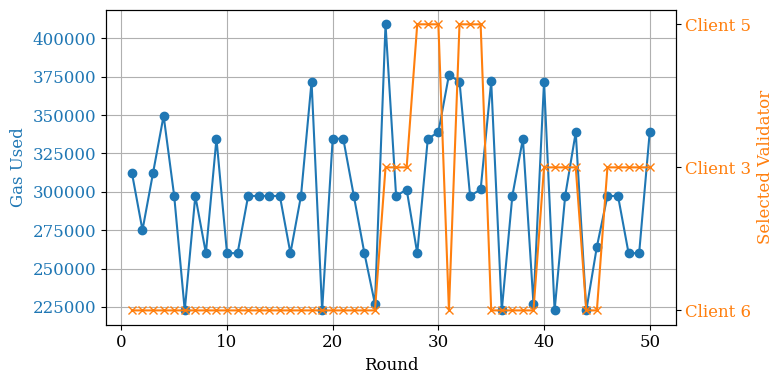

In [16]:

print("set 2-1: ")
run_test(K=6, N=50)
plot_results(K=6, N=50)

set 3-1: 
Running test with 10 clients and 50 rounds

Initialized reputation of client 0x86434733BC5cFd9DAa7F6a9fAefb91D31f2BFEC7 is 1008
Initialized reputation of client 0x02Fa249f75951c56549c8cf86c75b4Cbe04E6F4C is 1299
Initialized reputation of client 0x3c2595d4c5eC58fcBde6eBE5aD313F66AE4384Fb is 1327
Initialized reputation of client 0x89592a2c6aA603eF1526C09001793E7EAfb6f60C is 1146
Initialized reputation of client 0xba74589246157E8fE25F29f678B5738a51A454db is 1065
Initialized reputation of client 0x8BA41Feb6Da7467cb4685e0B58fE807E23167A41 is 1344
Initialized reputation of client 0xcc80E02Bd92BA8bAa55B9fEaB812bD0901fD68B6 is 1291
Initialized reputation of client 0xDBaBa224e5A3B4335F018D80D4192b8AE73e1a81 is 1056
Initialized reputation of client 0x1609f2a00BE7Ec35217Aa56f74116C230F7dF826 is 1306
Initialized reputation of client 0x21Cd8eD39827D49a37079D843846E26bC11D1b00 is 1140


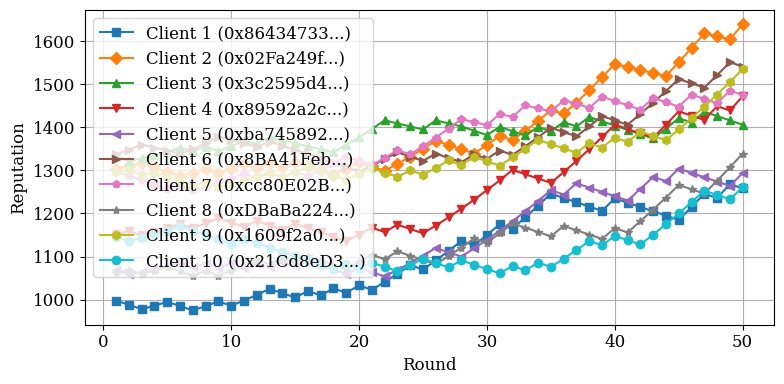

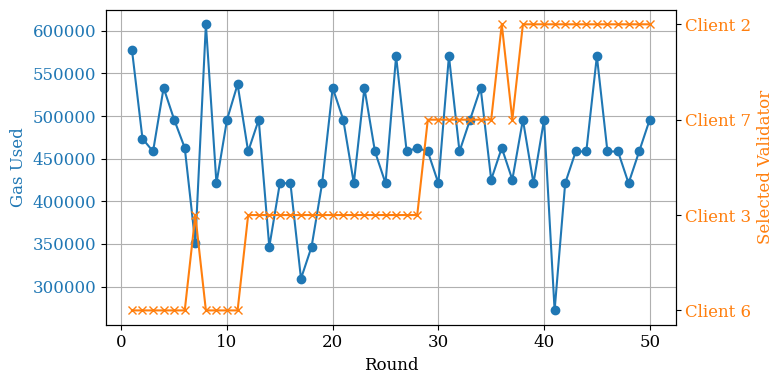

In [21]:
print("set 3-1: ")
run_test(K=10, N=50)
plot_results(K=10, N=50)

In [37]:
# Import necessary libraries
from web3 import Web3
import json
import solcx
import random
import matplotlib.pyplot as plt

# Connect to the local Ethereum network (Ganache)
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))

# Check if connection is successful
if not w3.is_connected():
    raise Exception("Failed to connect to the Ethereum network")

# Set the default account (deployer)
w3.eth.default_account = w3.eth.accounts[0]

# Compile the contract using solcx
solcx.install_solc('0.8.0')
solcx.set_solc_version('0.8.0')

# Path to your Solidity contract
contract_path = "./ProofOfReputation.sol"  # Update this path to your contract

# Compile the Solidity contract
with open(contract_path, "r") as file:
    contract_source_code = file.read()

compiled_sol = solcx.compile_standard({
    "language": "Solidity",
    "sources": {
        "ProofOfReputation.sol": {
            "content": contract_source_code
        }
    },
    "settings": {
        "outputSelection": {
            "*": {
                "*": ["abi", "metadata", "evm.bytecode", "evm.sourceMap"]
            }
        }
    }
})

# Extract ABI and bytecode
abi = compiled_sol['contracts']['ProofOfReputation.sol']['ProofOfReputation']['abi']
bytecode = compiled_sol['contracts']['ProofOfReputation.sol']['ProofOfReputation']['evm']['bytecode']['object']

# Deploy the contract
ProofOfReputation = w3.eth.contract(abi=abi, bytecode=bytecode)
tx_hash = ProofOfReputation.constructor().transact()
tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
contract_address = tx_receipt.contractAddress
print(f"Contract deployed at address: {contract_address}")

# Get the deployed contract instance
deployed_contract = w3.eth.contract(address=contract_address, abi=abi)

# Initialize data storage
reputation_history = {address: [] for address in w3.eth.accounts[1:]}  # Adjust for the number of clients
validation_costs = []
selected_validators = []

# Function to log gas used
def log_gas_usage(tx_hash, action):
    receipt = w3.eth.get_transaction_receipt(tx_hash)
    # print(f"Gas used for {action}: {receipt.gasUsed}")
    return receipt.gasUsed

# Add a new client with initialized parameters
def add_client(client_address, initial_reputation, historical_performance, trustworthiness, contribution, peer_reviews, validation_accuracy):
    try:
        tx_hash = deployed_contract.functions.addClient(
            client_address,
            initial_reputation,
            historical_performance,
            trustworthiness,
            contribution,
            peer_reviews,
            validation_accuracy
        ).transact()
    except Exception as e:
        print(f"Error adding client {client_address}: {str(e)}")

# Submit a job
def submit_job(client_address, job_result):
    try:
        tx_hash = deployed_contract.functions.submitJob(job_result).transact({'from': client_address})
    except Exception as e:
        print(f"Error submitting job by client {client_address}: {str(e)}")

# Validate all jobs, specifying success or failure for each client
def validate_all_jobs(validator_address, successes):
    try:
        tx_hash = deployed_contract.functions.validateAllJobs(successes).transact({'from': validator_address})
        gas_used = log_gas_usage(tx_hash, "Validating all jobs")
        validation_costs.append(gas_used)
    except Exception as e:
        print(f"Error validating jobs by validator {validator_address}: {str(e)}")

# Fetching updated reputations
def get_reputation(client_address):
    try:
        reputation = deployed_contract.functions.getReputationScore(client_address).call()
        return reputation
    except Exception as e:
        print(f"Error fetching reputation for client {client_address}: {str(e)}")
        return 0

# Run the test with K clients and N rounds
def run_test(K, N):
    print(f"Running test with {K} clients and {N} rounds\n")
    
    # Add K clients with initialized parameters
    for i in range(1, K + 1):
        # initial_reputation = random.randint(1000, 1500)
        initial_reputation = 1000
        historical_performance = random.randint(0, 10)
        trustworthiness = random.randint(0, 10)
        contribution = random.randint(0, 10)
        peer_reviews = random.randint(0, 10)
        validation_accuracy = random.randint(0, 10)

        add_client(
            w3.eth.accounts[i], 
            initial_reputation,
            historical_performance,
            trustworthiness,
            contribution,
            peer_reviews,
            validation_accuracy
        )
        print(f"Initialized reputation of client {w3.eth.accounts[i]} is {initial_reputation}")
    
    # Run N rounds of job submissions and validations
    for round_num in range(1, N + 1):
        # print(f"\n--- Round {round_num} ---")
        
        # Each client submits a job
        for i in range(1, K + 1):
            submit_job(w3.eth.accounts[i], f"Job {round_num} from Client {i}")
        
        # Randomly decide if each job is successful or not
        successes = [random.choice([True, False]) for _ in range(K)]

        # Validator validates all jobs
        current_validator = deployed_contract.functions.getCurrentValidator().call()
        # print(f"Current Validator: {current_validator}")
        validate_all_jobs(current_validator, successes)
        selected_validators.append(current_validator)
        
        # Store the updated reputations
        for i in range(1, K + 1):
            reputation = get_reputation(w3.eth.accounts[i])
            reputation_history[w3.eth.accounts[i]].append(reputation)

font = {'family': 'serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)
# Plot the results
def plot_results(K, N):
    rounds = list(range(1, N + 1))

    # Plot reputation per round
    plt.figure(figsize=(8, 4))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # List of markers for different lines
    for i in range(1, K + 1):
        plt.plot(rounds, reputation_history[w3.eth.accounts[i]], marker=markers[i % len(markers)], label=f"Client {i} ({w3.eth.accounts[i][:10]}...)")
    # plt.title('Reputation Per Round')
    plt.xlabel('Round')
    plt.ylabel('Reputation')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Combine validation cost and selected validators per round
    fig, ax1 = plt.subplots(figsize=(8, 4))

    color = 'tab:blue'
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Gas Used', color=color)
    ax1.plot(rounds, validation_costs, marker='o', color=color, linestyle='-', label='Validation Costs')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    validator_labels = [f"Client {i + 1}" for i in range(K)]
    validator_indices = [validator_labels[w3.eth.accounts.index(v) - 1] for v in selected_validators]
    ax2.set_ylabel('Selected Validator', color=color)
    ax2.plot(rounds, validator_indices, marker='x', linestyle='-', color=color, label='Selected Validators')
    ax2.tick_params(axis='y', labelcolor=color)

    # plt.title('Validation Costs and Selected Validators Per Round')
    plt.xlabel('Round')
    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.show()



Contract deployed at address: 0x79ad92979337A066bC4711FB4EFa7aE6C997641d


set 1-2: 
Running test with 3 clients and 50 rounds

Initialized reputation of client 0x86434733BC5cFd9DAa7F6a9fAefb91D31f2BFEC7 is 1000
Initialized reputation of client 0x02Fa249f75951c56549c8cf86c75b4Cbe04E6F4C is 1000
Initialized reputation of client 0x3c2595d4c5eC58fcBde6eBE5aD313F66AE4384Fb is 1000


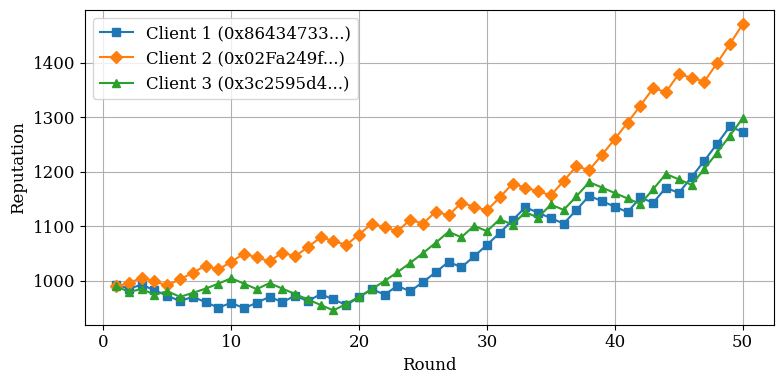

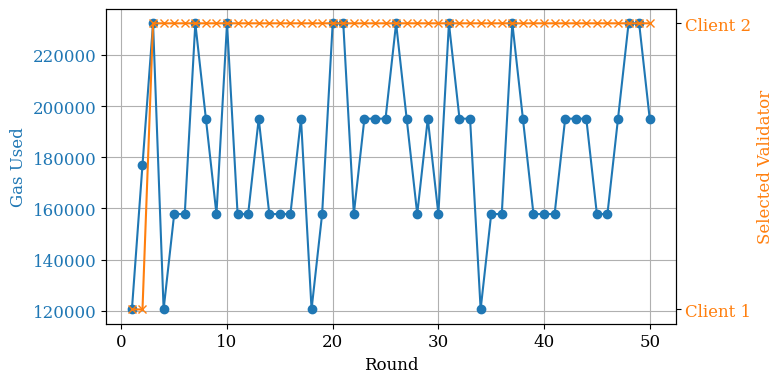

In [34]:
# Example usage: Test with 10 clients over 10 rounds
print("set 1-2: ")
run_test(K=3, N=50)
plot_results(K=3, N=50)




set 2-2: 
Running test with 6 clients and 50 rounds

Initialized reputation of client 0x86434733BC5cFd9DAa7F6a9fAefb91D31f2BFEC7 is 1000
Initialized reputation of client 0x02Fa249f75951c56549c8cf86c75b4Cbe04E6F4C is 1000
Initialized reputation of client 0x3c2595d4c5eC58fcBde6eBE5aD313F66AE4384Fb is 1000
Initialized reputation of client 0x89592a2c6aA603eF1526C09001793E7EAfb6f60C is 1000
Initialized reputation of client 0xba74589246157E8fE25F29f678B5738a51A454db is 1000
Initialized reputation of client 0x8BA41Feb6Da7467cb4685e0B58fE807E23167A41 is 1000


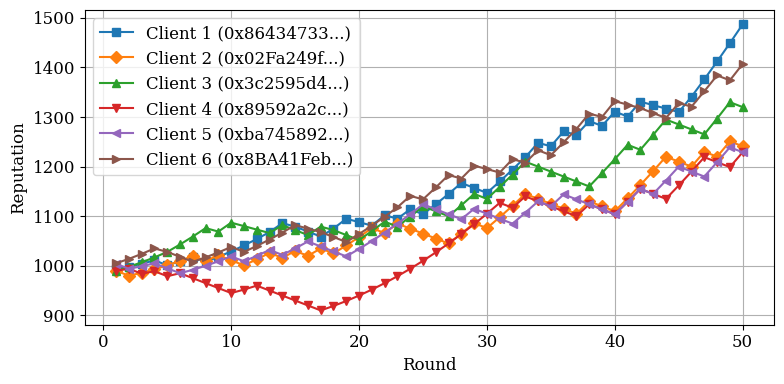

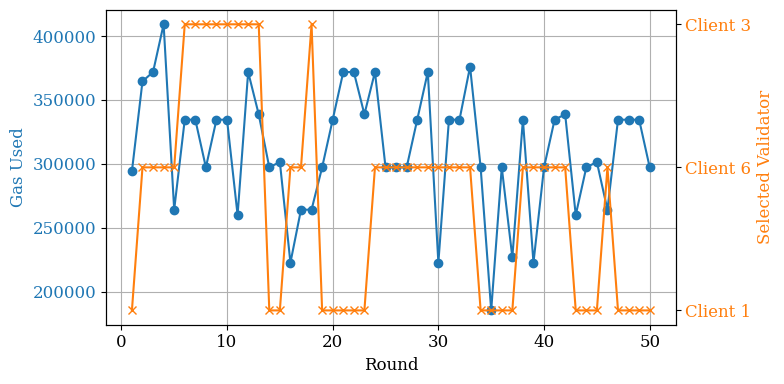

In [36]:
print("set 2-2: ")
run_test(K=6, N=50)
plot_results(K=6, N=50)



set 3-2: 
Running test with 10 clients and 50 rounds

Initialized reputation of client 0x86434733BC5cFd9DAa7F6a9fAefb91D31f2BFEC7 is 1000
Initialized reputation of client 0x02Fa249f75951c56549c8cf86c75b4Cbe04E6F4C is 1000
Initialized reputation of client 0x3c2595d4c5eC58fcBde6eBE5aD313F66AE4384Fb is 1000
Initialized reputation of client 0x89592a2c6aA603eF1526C09001793E7EAfb6f60C is 1000
Initialized reputation of client 0xba74589246157E8fE25F29f678B5738a51A454db is 1000
Initialized reputation of client 0x8BA41Feb6Da7467cb4685e0B58fE807E23167A41 is 1000
Initialized reputation of client 0xcc80E02Bd92BA8bAa55B9fEaB812bD0901fD68B6 is 1000
Initialized reputation of client 0xDBaBa224e5A3B4335F018D80D4192b8AE73e1a81 is 1000
Initialized reputation of client 0x1609f2a00BE7Ec35217Aa56f74116C230F7dF826 is 1000
Initialized reputation of client 0x21Cd8eD39827D49a37079D843846E26bC11D1b00 is 1000


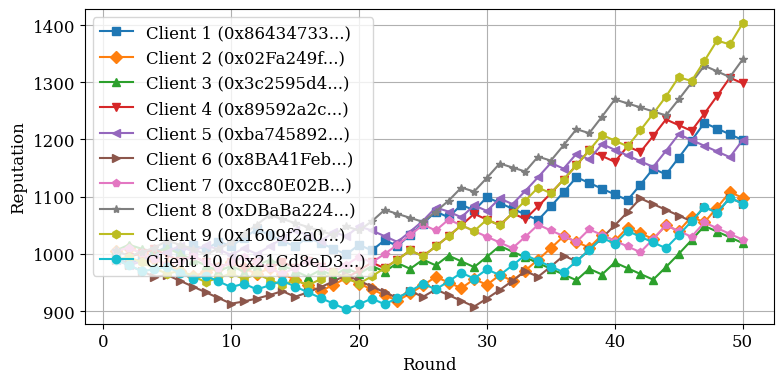

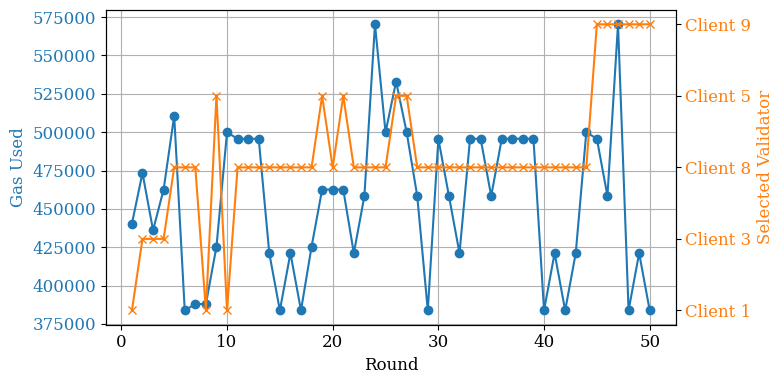

In [38]:
print("set 3-2: ")
run_test(K=10, N=50)
plot_results(K=10, N=50)